In [7]:
from sklearn.datasets import fetch_openml # From Scikit Learn, we get a function that is able to access datasets from OpenML via connecting to the internet

mnist = fetch_openml('mnist_784', as_frame=False) # We fetch the MNIST dataset. This datatype functions like a dictionary with attribute access
old_X, old_y = mnist.data, mnist.target # Split MNIST into images and their corresponding labels

In [8]:
import torch
import numpy as np

mask = (old_y == '0') | (old_y == '1')
X, y = old_X[mask], old_y[mask].astype(np.int64) # Make X and y only show 0 and 1s. Turn the labels, a string, to integers.

# Split dataset into training and testing
split = int(len(X) * 6 / 7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_X_half = torch.from_numpy(X[:split]).float().to(device) / 255
train_y_half = torch.from_numpy(y[:split]).float().view(-1, 1).to(device)
test_X_half = torch.from_numpy(X[split:]).float().to(device) / 255
test_y_half = torch.from_numpy(y[split:]).float().view(-1, 1).to(device)

# Augment our dataset to get its inverted image and shuffle
train_perm = torch.randperm(len(train_X_half) * 2)
test_perm = torch.randperm(len(test_X_half) * 2)
train_X = torch.vstack((train_X_half, 1 - train_X_half))[train_perm]
test_X = torch.vstack((test_X_half, 1 - test_X_half))[test_perm]
train_y = torch.vstack((train_y_half, train_y_half))[train_perm]
test_y = torch.vstack((test_y_half, test_y_half))[test_perm]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([25336, 784]),
 torch.Size([25336, 1]),
 torch.Size([4224, 784]),
 torch.Size([4224, 1]))

In [13]:
import torch.nn as nn
import torch.nn.functional as F

in_dim = 784
hidden_dim = 128
out_dim = 1

class BinMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(in_dim, hidden_dim, device=device))
        self.B1 = nn.Parameter(torch.randn(hidden_dim, device=device))
        self.W2 = nn.Parameter(torch.randn(hidden_dim, out_dim, device=device))
        self.B2 = nn.Parameter(torch.randn(out_dim, device=device))
    
    def forward(self, X):
        X2 = X @ self.W1 + self.B1 # (25336, 784) @ (784, 128) + (128)
        X3 = F.relu(X2) # Activation
        X4 = X3 @ self.W2 + self.B2 # (25336, 128) @ (128, 1) + (1)
        return X4 

model = BinMLP()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 10000

In [14]:
train_errors, test_errors = [], []

num_batches = 2
batch_size = len(train_X) // num_batches

for epoch in range(epochs):
    total_train_loss = 0.0 # Accumulate the losses
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size if i < num_batches - 1 else len(train_X)
        
        xb = train_X[start:end]
        yb = train_y[start:end]

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # average loss across all batches (to match full-batch semantics)
    avg_train_loss = total_train_loss / num_batches

    # evaluation (still full-batch, but you could batch test too if needed)
    with torch.no_grad():
        test_logits = model(test_X)
        test_loss = F.binary_cross_entropy_with_logits(test_logits, test_y).item()

    train_errors.append(avg_train_loss)
    test_errors.append(test_loss)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Train Loss={avg_train_loss:.4f}, Test Loss={test_loss:.4f}")


Epoch 0, Train Loss=37.2754, Test Loss=25.7800
Epoch 1000, Train Loss=0.0008, Test Loss=0.0147
Epoch 2000, Train Loss=0.0000, Test Loss=0.0132
Epoch 3000, Train Loss=0.0000, Test Loss=0.0126
Epoch 4000, Train Loss=0.0000, Test Loss=0.0122
Epoch 5000, Train Loss=0.0000, Test Loss=0.0118
Epoch 6000, Train Loss=0.0000, Test Loss=0.0114
Epoch 7000, Train Loss=0.0000, Test Loss=0.0112
Epoch 8000, Train Loss=0.0000, Test Loss=0.0109
Epoch 9000, Train Loss=0.0000, Test Loss=0.0106


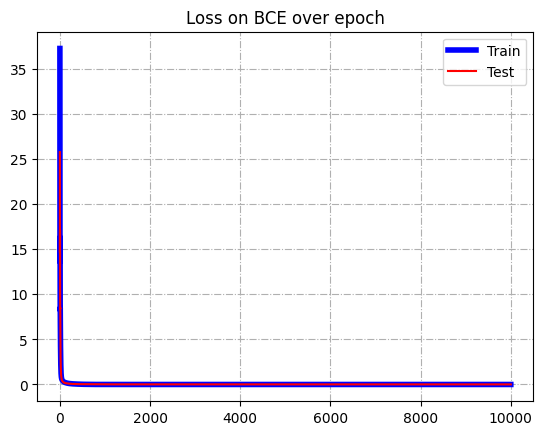

In [15]:
import matplotlib.pyplot as plt

xAxis = torch.linspace(0, len(train_errors) - 1, len(train_errors))
plt.plot(xAxis, train_errors, color='blue', linewidth=4, label='Train')
plt.plot(xAxis, test_errors, color='red', label='Test')
plt.title('Loss on BCE over epoch')
plt.grid(linestyle='-.')
plt.legend()
plt.show()

In [25]:
torch.save(model.state_dict(), '../inference/param/MNIST_bin_perceptron.pth')